In [ ]:
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore", category=UserWarning)     

In [89]:
# SQL Server (entorno local)
LOCAL_SERVER = 'localhost'
LOCAL_DATABASE = 'dwh_case1'
LOCAL_DRIVER = '{ODBC Driver 17 for SQL Server}'

# Construcción de cadena de conexión
local_conn_str = f"DRIVER={LOCAL_DRIVER};SERVER={LOCAL_SERVER};DATABASE={LOCAL_DATABASE};Trusted_Connection=yes;TrustServerCertificate=yes"
conn = pyodbc.connect(local_conn_str)

In [90]:
# Lectura de la consulta SQL desde archivo
with open("../Crear_tabla_para_regresión.sql", "r") as file:
    query = file.read()

# Ejecución de la consulta y carga del resultado en un DataFrame
df = pd.read_sql_query(query, conn)

In [91]:
df.head()

,PVP,Edad_Media_Coche,Km_Medio_Por_Revision,Margen_Medio,Revisiones_Media,churn_percentage
0,21818,1.979167,56905,33.0,1.0,0.083333
1,22814,2.015873,31952,33.0,1.0,0.238095
2,31968,3.166667,93782,43.0,1.0,0.166667
3,28719,1.666667,58609,43.0,1.0,0.000000
4,17550,1.953271,39867,33.0,1.0,0.098131


In [92]:
df.dtypes

PVP                        int64
Edad_Media_Coche         float64
Km_Medio_Por_Revision      int64
Margen_Medio             float64
Revisiones_Media         float64
churn_percentage         float64
dtype: object

In [93]:
df.describe()

,PVP,Edad_Media_Coche,Km_Medio_Por_Revision,Margen_Medio,Revisiones_Media,churn_percentage
count,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000
mean,24063.444115,2.017138,38664.610287,33.388021,1.000280,0.094212
std,5889.838997,0.769485,26341.123490,6.563956,0.001728,0.143344
min,10528.000000,-1.000000,0.000000,5.000000,1.000000,0.000000
25%,20359.000000,1.750000,22382.000000,33.000000,1.000000,0.000000
50%,23909.000000,2.016334,39469.000000,33.000000,1.000000,0.054054
75%,28183.500000,2.285714,52167.000000,33.000000,1.000000,0.141713
max,37970.000000,5.000000,204640.000000,43.000000,1.027027,1.000000


In [94]:
df.isnull().sum() # Valores nulos.

PVP                      0
Edad_Media_Coche         0
Km_Medio_Por_Revision    0
Margen_Medio             0
Revisiones_Media         0
churn_percentage         0
dtype: int64

In [95]:
df.duplicated().sum() # Valores duplicados.

np.int64(0)

Modelo regresion lineal 



In [96]:
# Definición de variables predictoras (X) y variable objetivo (y).
X = df[['PVP', 'Edad_Media_Coche', 'Km_Medio_Por_Revision', 'Margen_Medio']]
y = df['churn_percentage']

In [97]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [98]:
# Predicción del Churn.
y_pred = model.predict(X)
y_pred_clipped = np.clip(y_pred, 0, 1)

In [99]:
r2 = r2_score(y, y_pred_clipped)
mse = mean_squared_error(y, y_pred_clipped)
metrics_df = pd.DataFrame({
    'Métrica': ['R² (coef. de determinación)', 'MSE (error cuadrático medio)'],
    'Valor': [r2, mse]
})

print("Evaluación del modelo:")
display(metrics_df)

Evaluación del modelo:


,Métrica,Valor
0,R² (coef. de determinación),0.185005
1,MSE (error cuadrático medio),0.016730


In [100]:
coef_df = pd.DataFrame({
    'Variable': X.columns.tolist() + ['Intercepto'],
    'Coeficiente': model.coef_.tolist() + [model.intercept_]
})

print("Coeficientes estimados:")
display(coef_df)

Coeficientes estimados:


,Variable,Coeficiente
0,PVP,-5.924578e-06
1,Edad_Media_Coche,4.701716e-02
2,Km_Medio_Por_Revision,8.116491e-07
3,Margen_Medio,-1.191071e-03
4,Intercepto,1.503226e-01


In [101]:
cursor = conn.cursor()
table = "churn_coef"

# Creación de la tabla.
cursor.execute(f"""
IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='{table}' AND xtype='U')
CREATE TABLE {table} (
    Variable NVARCHAR(50) PRIMARY KEY,
    Coeficiente FLOAT
)
""")

# Vacio de la tabla antes de insertar nuevos coeficientes.
cursor.execute(f"DELETE FROM {table}")

# Inserción de coeficientes en la tabla.
insert_sql = f"INSERT INTO {table} (Variable, Coeficiente) VALUES (?, ?)"
for _, row in coef_df.iterrows():
    cursor.execute(insert_sql, row['Variable'], row['Coeficiente'])

conn.commit()
conn.close()
print(f"Tabla '{table}' creada y poblada correctamente.")

Tabla 'churn_coef' creada y poblada correctamente.


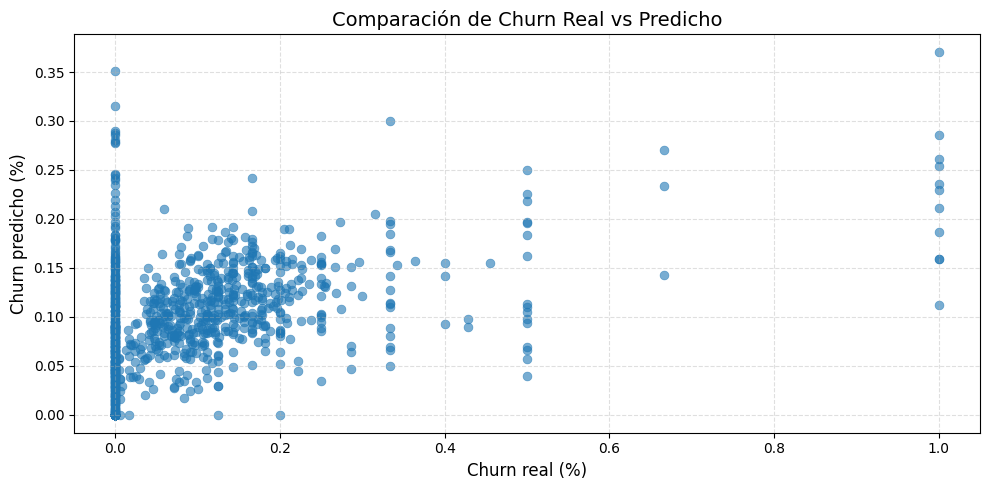

In [102]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y, y=y_pred_clipped, alpha=0.6, s=40, edgecolor=None)

plt.xlabel("Churn real (%)", fontsize=12)
plt.ylabel("Churn predicho (%)", fontsize=12)
plt.title("Comparación de Churn Real vs Predicho", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()